# Описание
Здесь представлен baseline для [соревнования](https://stepik.org/lesson/226979/step/1?unit=199528), 
который дается в конце курса ["Введение в Data Science и машинное обучение"](https://stepik.org/course/4852/) на stepic.

За основу взять признаки которые создавали в течении курса. ROC_AUC = 0.8792.

In [451]:
!pip install --upgrade category_encoders
!pip install --upgrade sklearn

Requirement already up-to-date: category_encoders in c:\anaconda\lib\site-packages (2.0.0)
  Running setup.py bdist_wheel for sklearn: started
  Running setup.py bdist_wheel for sklearn: finished with status 'done'
  Stored in directory: C:\Users\chief\AppData\Local\pip\Cache\wheels\76\03\bb\589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


# Импорт

In [452]:
%load_ext autoreload
%autoreload 2

import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm, tqdm_notebook
import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import PowerTransformer,QuantileTransformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import ColumnTransformer
import category_encoders



from sklearn.externals import joblib

import libs.data_helpers as dh
import libs.data_iter1 as di
import libs.utils.model_utils as mu
import libs.submit_report as rep

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from xgboost import XGBClassifier

seed = 496

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Загрузка и подготовка данных

In [453]:
# загрузка данных
events  = pd.read_csv("./data/event_data_train.zip")
submissions = pd.read_csv("./data/submissions_data_train.zip")

# разделение данных для обучения на train и test
_ = dh.split_events_submissions(events, submissions, test_size=0.2)
events_train_orig, events_test_orig, submissions_train_orig, submissions_test_orig = _

# подготовка данных
X_train, y_train = di.get_x_y(events_train_orig, submissions_train_orig, 5, True)
X_test, y_test = di.get_x_y(events_test_orig, submissions_test_orig, 5, True)

E:\Python\stepik_course_4852_contest\libs\data_helpers.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['date'] = pd.to_datetime(data.timestamp, unit='s')
E:\Python\stepik_course_4852_contest\libs\data_helpers.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['day'] = data.date.dt.date


In [454]:
X_train['correct_ratio'] = X_train.correct / (X_train.correct + X_train.wrong)
X_test['correct_ratio'] = X_test.correct / (X_test.correct + X_test.wrong)
X_train['steps_discoverd_passed'] = (X_train.discovered - X_train.passed) / X_train.day
X_test['steps_discoverd_passed'] = (X_test.discovered - X_test.passed) / X_test.day

In [455]:
# wrong ratio

In [456]:
# read train and test data
train_suc_users = pd.read_csv('data/users_train.csv',index_col = 0)
test_suc_users = pd.read_csv('data/users_test.csv',index_col = 0)


In [457]:
# merge the data
X_train = X_train.merge(train_suc_users, on = 'user_id', how = 'left')
X_test = X_test.merge(train_suc_users, on = 'user_id', how = 'left')

In [458]:
# add one more metric - tasks pro day?
#((X_train.correct + X_train.wrong) / X_train.day)

In [459]:
#X_train[X_train.correct/ X_train.day > 2]

In [460]:
# binary features + encoding

In [461]:
# filter the data by outliers?

In [462]:
# correlation

In [497]:
X_train.head(15)

,user_id,correct,wrong,discovered,passed,started_attempt,viewed,day,correct_ratio,steps_discoverd_passed,has_success_hard_attempts
0,1,0.0,0.0,1,0,0,1,1,NaN,1.0,NaN
1,2,2.0,0.0,9,9,2,9,1,1.000000,0.0,False
2,3,4.0,4.0,15,15,4,20,1,0.500000,0.0,False
3,5,2.0,2.0,1,1,0,1,1,0.500000,0.0,NaN
4,7,0.0,0.0,1,1,0,1,1,NaN,0.0,NaN
5,8,9.0,21.0,109,84,37,154,1,0.300000,25.0,False
6,11,0.0,0.0,1,0,1,1,1,NaN,1.0,NaN
7,14,0.0,1.0,4,3,1,9,1,0.000000,1.0,False
8,24,0.0,0.0,1,1,0,2,1,NaN,0.0,NaN
9,25,1.0,4.0,26,20,10,40,2,0.200000,3.0,False


In [464]:
X_test.head()

,user_id,correct,wrong,discovered,passed,started_attempt,viewed,day,correct_ratio,steps_discoverd_passed,has_success_hard_attempts
0,9,0.0,0.0,3,3,0,4,1,NaN,0.00,NaN
1,16,23.0,28.0,59,58,27,140,4,0.45098,0.25,True
2,17,0.0,2.0,6,5,1,13,1,0.00000,1.00,False
3,18,0.0,0.0,3,2,0,3,1,NaN,1.00,NaN
4,20,0.0,0.0,10,8,0,13,1,NaN,2.00,NaN


In [483]:
# normalise the data with gaps fill using sklearn
df_num_features = X_train.columns.copy()
df_num_features = df_num_features.drop('has_success_hard_attempts')
df_cat_features = [list(X_train)[-1]]
#df_num_features

num_features_pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='median',copy = False)), # with median a little bit better
    ('scale', MinMaxScaler()),
    ('transform', QuantileTransformer(output_distribution='normal'))
])

cat_bin_features_pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_features_pipeline, df_num_features),
        ('cat_bin', cat_bin_features_pipeline, df_cat_features)
    ]
)

In [484]:
baseline_transform = Pipeline(
    steps=[
        ('preprocessing', preprocessor)
    ]
)

In [485]:
X_train_p = baseline_transform.fit_transform(X_train)
X_test_p = baseline_transform.transform(X_test)

Index(['user_id', 'correct', 'wrong', 'discovered', 'passed',
       'started_attempt', 'viewed', 'day', 'correct_ratio',
       'steps_discoverd_passed', 'has_success_hard_attempts'],
      dtype='object')

In [503]:

#pd.DataFrame(X_train_p, index=X_train.index, columns=X_train.columns)

# Обучение и проверка модели

NEural network use

## RandomForest

In [508]:
rf = RandomForestClassifier(criterion='entropy',n_estimators=100, n_jobs=-1, 
                            min_samples_leaf=10, min_samples_split=10, 
                            class_weight='balanced', random_state = seed)

rf.fit(X_train_p, y_train)
pred_proba = rf.predict_proba(X_test_p)
roc_score = roc_auc_score(y_test, pred_proba[:, 1])
print('roc на test', roc_score)
# должны получить roc 0.92  +- 0.02

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=496,
            verbose=0, warm_start=False)

roc на test 0.9464469080207272


In [509]:
skv_gs = StratifiedKFold(n_splits = 5, random_state=seed, shuffle=True)
my_scorer = make_scorer(roc_auc_score)
    
tuned_parameters = [{
    'n_estimators' : [30, 50, 100],
    'max_depth': [7, 9, 11, 13],
    'min_samples_leaf' : [7, 9, 15],
    'min_samples_split' : [50, 75, 100]
                    }]
    
bclf = GridSearchCV(rf, tuned_parameters,
                        scoring=my_scorer, cv=skv_gs, verbose=1, n_jobs=-1,refit='roc_auc')

In [510]:
bclf.fit(X_train_p, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=496, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=496,
            verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [30, 50, 100], 'max_depth': [7, 9, 11, 13], 'min_samples_leaf': [7, 9, 15], 'min_samples_split': [50, 75, 100]}],
       pre_dispatch='2*n_jobs', refit='roc_auc', return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=1)

In [511]:
bclf.best_params_

{'max_depth': 13,
 'min_samples_leaf': 9,
 'min_samples_split': 100,
 'n_estimators': 50}

In [512]:
pred_proba = bclf.predict_proba(X_test_p)
roc_score = roc_auc_score(y_test, pred_proba[:, 1])
print('roc на test', roc_score)

roc на test 0.9461103561048505


In [513]:
rf = bclf.best_estimator_

best params
{'max_depth': 13,
 'min_samples_leaf': 9,
 'min_samples_split': 100,
 'n_estimators': 50

In [514]:
'''best_params ={'max_depth': 11,
 'min_samples_leaf': 15,
 'min_samples_split': 75,
 'n_estimators': 50}
rf = RandomForestClassifier(criterion='entropy',n_jobs=-1, 
                            class_weight='balanced', random_state = seed, **best_params)

rf.fit(X_train_p, y_train)
pred_proba = rf.predict_proba(X_test_p)
roc_score = roc_auc_score(y_test, pred_proba[:, 1])
print('roc на test', roc_score)'''

"best_params ={'max_depth': 11,\n 'min_samples_leaf': 15,\n 'min_samples_split': 75,\n 'n_estimators': 50}\nrf = RandomForestClassifier(criterion='entropy',n_jobs=-1, \n                            class_weight='balanced', random_state = seed, **best_params)\n\nrf.fit(X_train_p, y_train)\npred_proba = rf.predict_proba(X_test_p)\nroc_score = roc_auc_score(y_test, pred_proba[:, 1])\nprint('roc на test', roc_score)"

<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic example')

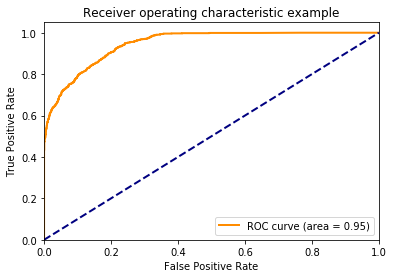

In [515]:
lw = 2
fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# важность фич
fimp = mu.get_feature_importances_df(rf.feature_importances_, X_train.columns)
fimp.head(15)

## кроссвалидация

In [516]:
# значение к метрике на кроссвалидации коррелирует к метрике на степике

rfcv = RandomForestClassifier(**rf.get_params())

cv_scores = cross_val_score(rfcv, X_train_p, y_train, scoring='roc_auc', cv=10, n_jobs=-1)
mean_cv_scores = np.mean(cv_scores)
print ('mean score', mean_cv_scores)

mean score 0.9421885203999268


## Сохранение модели

In [267]:
# Расскоментируйте, если нужно сохранить модель
# !mkdir ./bin_models
# joblib.dump(rf, './bin_models/baseline_random_forest.bin')

# код для загрузки модели
# rf = joblib.load('./bin_models/baseline_random_forest.bin')

# Сделать предсказание по сабмиту

In [517]:
SUBMIT_NUM = 9

events_pred  = pd.read_csv("./data/events_data_test.zip")
submissions_pred = pd.read_csv("./data/submission_data_test.zip")
X_pred , y_pred = di.get_x_y(events_pred, submissions_pred, 3, False)

In [379]:
#X_pred , y_pred

In [518]:
X_pred['correct_ratio'] = X_pred.correct / (X_pred.correct + X_pred.wrong)
X_pred['steps_discoverd_passed'] = (X_pred.discovered - X_pred.passed) / X_pred.day
X_pred = X_pred.merge(test_suc_users, on = 'user_id', how = 'left')

In [519]:
X_pred_p = baseline_transform.transform(X_pred)

In [520]:
rf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=13, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=9,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=-1, oob_score=False, random_state=496,
            verbose=0, warm_start=False)>

In [ ]:
# pay attention to classifier
pred_proba = rf.predict_proba(X_pred_p)[:, 1]

In [523]:
rep_df = rep.create_report(X_pred.index, pred_proba)
# assert rep_df.user_id.nunique() == X_pred.index.nunique()
print ('Прогноз сохранен в файл ', rep.save_report(rep_df, SUBMIT_NUM))

print ('Распределение "вероятностей" модели')
pd.cut(pred_proba, 10).value_counts()

Прогноз сохранен в файл  ./reports/predict_2019-06-01_submit_9.csv
Распределение "вероятностей" модели


(-0.001, 0.1]    3308
(0.1, 0.2]        123
(0.2, 0.3]        198
(0.3, 0.4]        373
(0.4, 0.5]        643
(0.5, 0.6]        429
(0.6, 0.7]        297
(0.7, 0.8]        208
(0.8, 0.9]        161
(0.9, 1.0]        444
dtype: int64

In [530]:
pred_proba.shape

(6184,)

In [538]:
X_pred['is_gone'] = pred_proba
X_pred[['user_id', 'is_gone']].to_csv('reports/predict_2019-06-01_submit_9_rf_new_feature.csv',index=False)

описательные - признаки, которые описывают прохождение курса пользователем на имеющихся данных (колво пройденных/просмотренных степов, колво попыток и т.д). Это baseline + несколько производных
признаки степов - характеристики степов и то как и проходят пользователи, например сложность(% успешных прохождений). Подымает скор по сравнению с baseline
поведенческие - ﻿признаки того как пользователь проходит степы изо дня в день. Попытка описать дисциплину, тенденции. Не проверял на сабмите, потому что на тесте получил прирост в рамках отклонения

In [313]:
roc_score = roc_auc_score(y_pred, pred_proba)
print('roc на test', roc_score)

roc на test 0.999447737874529


### XGBoost.

In [154]:
params={
    'n_estimators':500,
    'objective': 'binary:logistic',
    'learning_rate': 0.05,
    # 'gamma':0.01,
    'subsample':0.7,
    'colsample_bytree':0.3,
    'min_child_weight':4,
    'max_depth':5,
    'random_state':seed,
    'eval_metric':'auc',
    
    }

xbg_clf = XGBClassifier(**params)

In [155]:
xbg_clf.fit(X_train_p,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, eval_metric='auc', gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=500, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=496,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

In [156]:
pred_proba = xbg_clf.predict_proba(X_test_p)
roc_score = roc_auc_score(y_test, pred_proba[:, 1])
print('roc на test', roc_score)

roc на test 0.9252449630019497


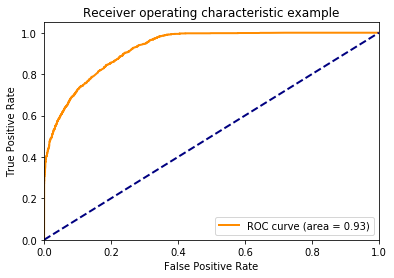

In [157]:
lw = 2
fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show();

In [158]:
cv_scores = cross_val_score(xbg_clf, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1)
mean_cv_scores = np.mean(cv_scores)
print ('mean score', mean_cv_scores)

mean score 0.9236101455924143


In [160]:
fimp = mu.get_feature_importances_df(xbg_clf.feature_importances_, X_train.columns)
fimp.head(15)

,weight
viewed,0.162994
discovered,0.137757
correct_ratio,0.126924
correct,0.108211
diff_discoverd_passed,0.106857
passed,0.103410
wrong,0.103041
started_attempt,0.090730
day,0.060076


In [539]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
xgb = XGBClassifier(learning_rate=0.01, n_estimators=600, 
                    objective='binary:logistic',
                    verbosity = 1,
                    random_state=seed,
                    eval_metric = 'auc'
                   
                   )

In [540]:
skv_gs = StratifiedKFold(n_splits = 5, random_state=seed, shuffle=True)
my_scorer = make_scorer(roc_auc_score)
param_comb = 15    
# bclf = GridSearchCV(xgb, params,
#                         scoring=my_scorer, cv=skv_gs, verbose=1, n_jobs=-1,refit='roc_auc')

bclf = RandomizedSearchCV(xgb, 
                                   param_distributions=params, 
                                   n_iter=param_comb, 
                                   scoring=my_scorer, 
                                   n_jobs=-1, 
                                   cv=skv_gs, 
                                   verbose=1,
                                   random_state=seed)

In [541]:
bclf.fit(X_train_p, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  2.7min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=496, shuffle=True),
          error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.01,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=600, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=496, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=15, n_jobs=-1,
          param_distributions={'min_child_weight': [1, 5, 10], 'gamma': [0.5, 1, 1.5, 2, 5], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'max_depth': [3, 4, 5]},
          pre_dispatch='2*n_jobs', random_state=496, refit=True,
          return_train_score='warn', scoring=make_scorer(roc_auc_score),
          verbose=1)

In [542]:
pred_proba = bclf.predict_proba(X_test_p)
roc_score = roc_auc_score(y_test, pred_proba[:, 1])
print('roc на test', roc_score)

roc на test 0.9466129890748665


xgboost best params
{'subsample': 0.8,
 'min_child_weight': 1,
 'max_depth': 5,
 'gamma': 2,
 'colsample_bytree': 0.6}

In [340]:
# важность фич
fimp = mu.get_feature_importances_df(bclf.best_estimator_.feature_importances_, X_train.columns)
fimp.head(15)

,weight
correct_ratio,0.147329
passed,0.147001
correct,0.138244
discovered,0.129159
viewed,0.111646
started_attempt,0.100810
wrong,0.092710
steps_discoverd_passed,0.071585
day,0.061515


## кроссвалидация

In [341]:
# значение к метрике на кроссвалидации коррелирует к метрике на степике

#rfcv = RandomForestClassifier(**rf.get_params())

cv_scores = cross_val_score(bclf.best_estimator_, X_train_p, y_train, scoring='roc_auc', cv=5, n_jobs=-1)
mean_cv_scores = np.mean(cv_scores)
print ('mean score', mean_cv_scores)

mean score 0.9439641638929915


## Сохранение модели

In [267]:
# Расскоментируйте, если нужно сохранить модель
# !mkdir ./bin_models
# joblib.dump(rf, './bin_models/baseline_random_forest.bin')

# код для загрузки модели
# rf = joblib.load('./bin_models/baseline_random_forest.bin')

# Сделать предсказание по сабмиту

In [548]:
SUBMIT_NUM = 10

events_pred  = pd.read_csv("./data/events_data_test.zip")
submissions_pred = pd.read_csv("./data/submission_data_test.zip")
X_pred , y_pred = di.get_x_y(events_pred, submissions_pred, 3, False)

In [549]:
X_pred['correct_ratio'] = X_pred.correct / (X_pred.correct + X_pred.wrong)
X_pred['steps_discoverd_passed'] = (X_pred.discovered - X_pred.passed) / X_pred.day
X_pred = X_pred.merge(test_suc_users, on = 'user_id', how = 'left')

In [550]:
X_pred_p = baseline_transform.transform(X_pred)

In [551]:
pred_proba = bclf.predict_proba(X_pred_p)[:, 1]
X_pred['is_gone'] = pred_proba
X_pred[['user_id', 'is_gone']].to_csv('reports/predict_2019-06-01_submit_10_xgb_new_feature.csv',index=False)

In [352]:
# pay attention to classifier
pred_proba = bclf.predict_proba(X_pred_p)[:, 1]
rep_df = rep.create_report(X_pred.index, pred_proba)
assert rep_df.user_id.nunique() == X_pred.index.nunique()
print ('Прогноз сохранен в файл ', rep.save_report(rep_df, SUBMIT_NUM))

print ('Распределение "вероятностей" модели')
pd.cut(pred_proba, 10).value_counts()

Прогноз сохранен в файл  ./reports/predict_2019-06-01_submit_7.csv
Распределение "вероятностей" модели


(0.00127, 0.102]    3494
(0.102, 0.201]       637
(0.201, 0.301]       830
(0.301, 0.401]       269
(0.401, 0.5]         231
(0.5, 0.6]           121
(0.6, 0.699]          44
(0.699, 0.799]        95
(0.799, 0.898]        33
(0.898, 0.998]       430
dtype: int64

In [547]:
pred_proba.shape

(6184,)

In [354]:
roc_score = roc_auc_score(y_pred, pred_proba)
print('roc на test', roc_score)

roc на test 0.9999107596734644


### SVC

In [27]:
svc = SVC(kernel = 'linear',
          gamma = 'scale',
          C = 1, #наилучший С был получен в одной из попыток, похоже классификатор не очень хорошо может задать разделяющую плоскость. 
          random_state = seed,          
          decision_function_shape = 'ovr',                             
          class_weight = 'balanced',     
          probability = True)

svc.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
  max_iter=-1, probability=True, random_state=496, shrinking=True,
  tol=0.001, verbose=False)

In [28]:
pred_proba = svc.predict_proba(X_test)
roc_score = roc_auc_score(y_test, pred_proba[:, 1])
print('roc на test', roc_score)

roc на test 0.9147754157419316


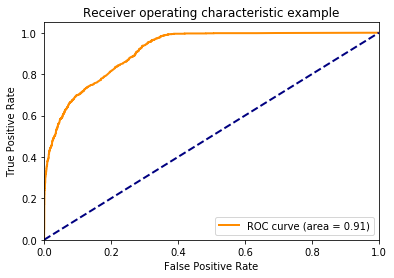

In [29]:
lw = 2
fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show();

In [41]:
my_scorer = make_scorer(roc_auc_score)
skv = StratifiedKFold(n_splits = 5,random_state=seed, shuffle=True)

param_grid = {
    'C': [0.01, 0.1, 0.3, 0.5, 0.8, 1.5, 5, 10],
    'kernel': ['linear', 'rbf', 'poly']
}


bclf = GridSearchCV(svc, param_grid,
                   scoring=my_scorer, cv=skv, verbose=9, n_jobs=-1,refit='roc_auc')

In [42]:
bclf.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 61.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=496, shuffle=True),
       error_score='raise-deprecating',
       estimator=SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
  max_iter=-1, probability=True, random_state=496, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 0.3, 0.5, 0.8, 1.5, 5, 10], 'kernel': ['linear', 'rbf', 'poly']},
       pre_dispatch='2*n_jobs', refit='roc_auc', return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=9)

In [46]:
bclf.best_params_
best_clf = bclf.best_estimator_

{'C': 10, 'kernel': 'rbf'}

In [47]:
pred_proba = best_clf.predict_proba(X_test)
roc_score = roc_auc_score(y_test, pred_proba[:, 1])
print('roc на test', roc_score)

roc на test 0.9143986617698912


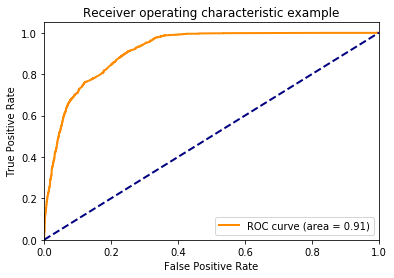

In [48]:
lw = 2
fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show();

In [49]:
SUBMIT_NUM = 2

events_pred  = pd.read_csv("./data/events_data_test.zip")
submissions_pred = pd.read_csv("./data/submission_data_test.zip")
X_pred , _ = di.get_x_y(events_pred, submissions_pred)

X_pred['correct_ratio'] = X_pred.correct / (X_pred.correct + X_pred.wrong)
X_pred.correct_ratio.fillna(0,inplace=True)

In [50]:
pred_proba = bclf.predict_proba(X_pred)[:, 1]
rep_df = rep.create_report(X_pred.index, pred_proba)
assert rep_df.user_id.nunique() == X_pred.index.nunique()
print ('Прогноз сохранен в файл ', rep.save_report(rep_df, SUBMIT_NUM))

print ('Распределение "вероятностей" модели')
pd.cut(pred_proba, 10).value_counts()

Прогноз сохранен в файл  ./reports/predict_2019-06-01_submit_2.csv
Распределение "вероятностей" модели


(-0.000786, 0.0994]    3683
(0.0994, 0.199]         316
(0.199, 0.298]          218
(0.298, 0.397]          277
(0.397, 0.496]          342
(0.496, 0.596]          274
(0.596, 0.695]          718
(0.695, 0.794]          199
(0.794, 0.893]          112
(0.893, 0.992]           45
dtype: int64